In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from pandas_datareader import data, wb
import pandas as pd
import datetime as dt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.stats.diagnostic
import statsmodels.tsa
import statsmodels.graphics

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')


In [2]:
# np.set_printoptions(precision=3)
# np.set_printoptions(suppress=True)

# <font face="gotham" color="purple"> Stochastic Processes and Stationarity </font> 

Loosely speaking, the **stochastic process** is a branch of mathematics that studies a family of random variables which are indexed by time. And time series data is a series of **realization** of a stochastic process. 

The **stationarity** is a general concept to describe a stochastic process or a time series.

For instance, we denote $\text{GDP}$ as $Y_t$ which is a stochastic process, however the indexed $Y_1$ and $Y_2$ are two different random variables. E.g. $Y_1 = 12345$, it means a realization at period $1$. 

A time series $\{r_t\}$ is _weakly stationary_, if $E(r_t)= \mu$ and $\text{Cov}(r_t, r_{t-k})= \gamma_k$, where $k$ is the number of lag.

This property tells that the mean and the variance are _time-invariant_.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
  <h3>Why do we care about <i>stationarity</i>? </h3>
<p>If a time series is nonstationary, we can only study the behavior in a particular episode and whatever conclusion we draw from the available sample can't be generalized to other episodes. Therefore forecasting nonstationary time series would absolutely be of little value. </p>
</div> 

Most of economic and financial time series are non-stationary, however they are usually weakly stationary at the first difference, such as log return.

# <font face="gotham" color="purple"> Removing Trend </font>

There are three approaches to removing trends from time series. The goal of them is to transform the series into stationarity.

## <font face="gotham" color="purple"> Differencing </font>

Differencing  proceeds under the assumption that $\{Y_t\}$ obey
$$
Y_t = Y_0 \epsilon^{u_t}\\
u_t= \gamma + u_{t-1}+e_t
$$
where $e_t$ is the white noise.

Taking logs,
$$
y_t=y_0 +u_t
$$
Take first difference
$$
y_t - y_{t-1} = u_t - u_{t-1}=\gamma+e_t
$$

In this case, $y_t$ is said to be **difference stationary**.

## <font face="gotham" color="purple"> Linear Detrending </font>

Linear detrending proceeds under the assumption that the level series $\{Y_t\}$ obeys
$$
Y_t= Y_0(1+g)^t\epsilon^{u_t}
$$
where $u_t$ is white noise. And taking logs,
$$
y_t = y_0+t\ln(1+g)+u_t\text{ or }\\
y_t\approx  y_0+gt+u_t
$$

To remove the trend 
$$
\hat{y}_t = y_t -\hat{\alpha}_0 -\hat{\alpha}_1t
$$
where $\alpha_0$ and $\alpha_1$ are OLS estimates. $\hat{y}_t$ is said to be **trend difference**.

Basically speaking, linear detrending assumes a constant growth rate (exponential growth of level), which is reasonable for some macro variables without visible shocks. 

## <font face="gotham" color="purple"> Filtering  </font>

The third approach are commonly used in business cycle research, popular in academia, which assumes a slowly evolving nonlinear trend. 

The standard tool of separating cycles from trend is **Hodrick-Prescott filter** (H-P) filter, which decomposes the $y_t$ as
$$
y_t = g_t + c_t 
$$
where $g_t$ and $c_t$ denote trend(growth) and cyclical component respectively.

H-P filter estimates $g_t$ and $c_t$ by minimizing the objective function
$$
\sum_{t=1}^Tc_t^2+\lambda \sum_{t=3}^T[(1-L)^2g_t]^2
$$
taking $\lambda$ as given, the larger the $\lambda$ the smoother the trend line estimated, as you can imagine as $\lambda\rightarrow \infty$, the trend is linear.

A value of 1600 is suggested for quarterly data. Ravn and Uhlig suggest using a value of $6.25 (1600/4^4)$ for annual data and $129600 (1600\times3^4)$ for monthly data.

To give some concrete example, let decompose the  macro data from national account, i.e. $Y= C+I+G+NX$

In [3]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime.today()
# real GDP per cap, gross investment, export, personal consumtpion expenditure
df = data.DataReader(['A939RX0Q048SBEA', 'GPDI', 'NETEXC', 'A794RX0Q048SBEA'], 'fred', start, end) 
df.columns = ['real_GDP_percap', 'Gross_Inv', 'Net_Ex', 'Person_Exp']

In [4]:
df_cycle = pd.DataFrame()
df_trend = pd.DataFrame()

In [5]:
for index in df.columns:
    cycle, trend = sm.tsa.filters.hpfilter(df[index].dropna())
    #cycle, trend = cycle.to_frame(), trend.to_frame()
    df_cycle = df_cycle.join(cycle, how='outer') # outer join, in case the time index length not matching
    df_trend = df_trend.join(trend, how='outer')

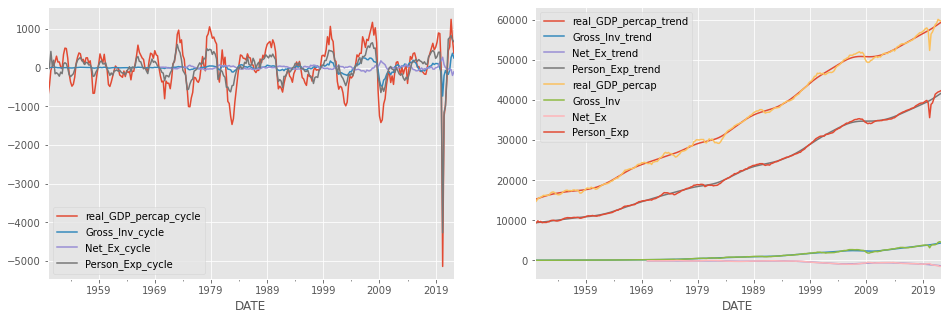

In [6]:
fig, ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
df_cycle.plot(ax=ax[0])
df_trend.plot(ax=ax[1])
df.plot(ax=ax[1])
plt.show()

# <font face="gotham" color="purple"> Stationarity Tests </font>

In this section, we will discuss some most popular stationarity tests.

Next we will refresh the methods for testing stationarity, first let's load $\text{EURUSD}$ daily series

In [7]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.today()
df = data.DataReader(['EURUSD=X'], 'yahoo', start, end)['Close'] # pick close price
df = df.join(np.log(df).add_suffix('_log'))
df.columns = ['EURUSD', 'EURUSD_log']

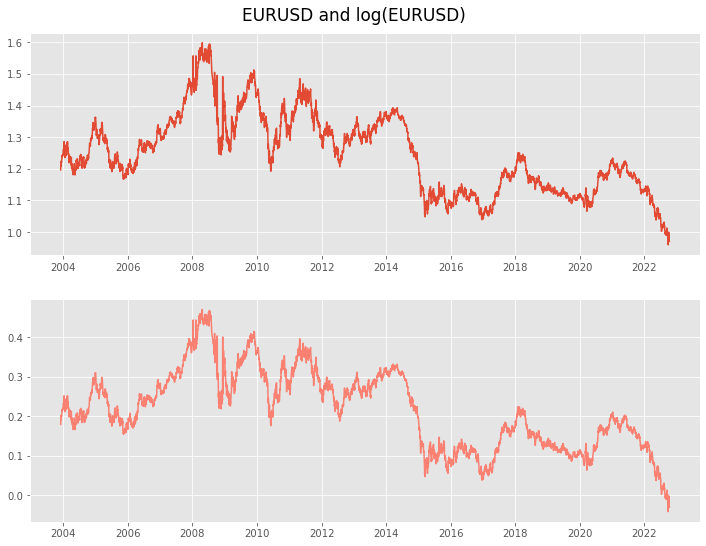

In [8]:
fig, ax = plt.subplots(figsize=(12, 9), ncols=1, nrows=2)
ax[0].plot(df['EURUSD'])
ax[1].plot(df['EURUSD_log'], color='salmon')
plt.suptitle('EURUSD and log(EURUSD)', y=.92, size=17)
plt.show()

## <font face="gotham" color="purple"> Dickey–Fuller (DF) test </font>

The default stationarity test is **Dickey-Fuller** (DF) test.

If we suspect that $Y_t$ follows a unit root process, it would be tempting to simply regress $Y_t$ onto $Y_{t-1}$, i.e. 
$$
Y_{t}=\rho Y_{t-1}+u_{t} \quad-1 \leq \rho \leq 1
$$
and hoping $\rho=1$. In practice, we estimate another form of it.

Some manipulation can bring in more insights
\begin{aligned}
Y_{t}-Y_{t-1} &=\rho Y_{t-1}-Y_{t-1}+u_{t} \\
&=(\rho-1) Y_{t-1}+u_{t}\\
\Delta Y_t &= \delta Y_{t-1}+u_{t}
\end{aligned}
where $\delta = \rho-1$. If $\delta =0$, i.e. $\rho=1$, then $\Delta Y_t = u_t$, therefore $Y_t$ is unstationary; if $\delta <0$, then $\rho <1$, in that case $Y_t$ is stationary.

The last equation $\Delta Y_t = \delta Y_{t-1}+u_{t}$ is the one to estimate for unit root and hypotheses are 
$$
H_0: \delta = 0, \text{unstationary}\\
H_1: \delta < 0, \text{stationary}
$$

It turns out the $t$-statistic calculated on $\delta$ doesn't really follow a $t$-distribution, it actually follows $\tau$-distribution or **Dickey-Fuller distribution**, therefore we call it _Dickey-Fuller test_.

The function of DF test has been imported at the top of this notebook, however we still need to customize the output for easy access. ```adf_test``` has been documented in ```tseries_func.py``` as well.

Also we need to point out, this ```adf``` function is in fact **Augmented Dicky-Fuller test**. which is a more general and robust test in order to void serial correlation of $u_t$, technical details are safely omitted, all mechanisms are the same as the former one.

In [9]:
def adf_test(x):
    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]
    
    adf_results_all = adfuller(x, autolag="BIC") # you can try 'AIC' too, I personaly prefer 'BIC'
    results = pd.Series(adf_results_all[0:4], index=indices)
    
    for key, value in adf_results_all[4].items():
        results['Critical Value ({})'.format(key)] = value
    results = pd.DataFrame(results, columns = ['statistics'])
    return pd.DataFrame(results)

In [10]:
adf_test(df['EURUSD_log'])

,statistics
Test Statistic,-1.246691
p-value,0.653195
# of Lags Used,2.000000
# of Observations Used,4889.000000
Critical Value (1%),-3.431688
Critical Value (5%),-2.862131
Critical Value (10%),-2.567085


The test result obviously fail to reject null hypothesis (high p-value) and it will certainly fail again in the future when you re-run this notebook. 

Like we said, the first order difference of log will be stationary, because it approximate the rate of change. Let's take a look.

In [11]:
df = df.join(df[['EURUSD_log']].diff().add_suffix('_return'), how='right')

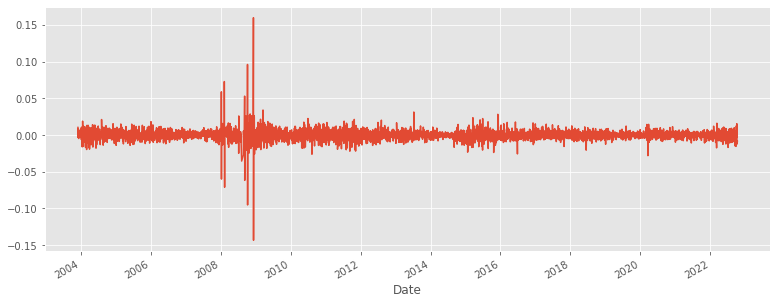

In [12]:
df['EURUSD_log_return'].plot(figsize=(13, 5)); plt.show()

From a first look, the data has some weird outlier, considering that we are watching $\text{EURUSD}$ ($5\%$ daily volatility in major currency is extremely rare), it is extremely likely those figures are  mis-recording.

The way to correct are simple, compare multiple resources, or verify with TradingView's public data. Or even simple, just remove all outliers larger than $5\%$ or any other threshold.

In [13]:
df['EURUSD_log_return'][abs(df['EURUSD_log_return'])>.05]=np.nan

Looks seemingly stationary, though not quite (variance changing). Put to DF test.

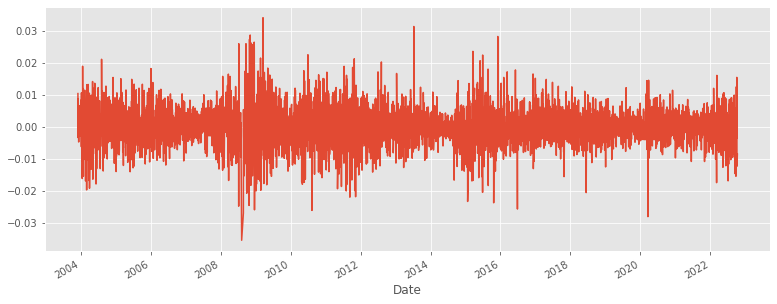

In [14]:
df = df.dropna()
df['EURUSD_log_return'].plot(figsize=(13, 5)); plt.show()

In [15]:
adf_test(df['EURUSD_log_return'])

,statistics
Test Statistic,-71.641078
p-value,0.000000
# of Lags Used,0.000000
# of Observations Used,4880.000000
Critical Value (1%),-3.431691
Critical Value (5%),-2.862132
Critical Value (10%),-2.567085


The test reveals that the statistics are highly significant against the $H_0$ which stands for non-stationarity.

## <font face="gotham" color="purple"> KPSS Test </font>

The complementary test of ADF is **Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test**, in contrast to ADF test which tests **difference stationary** (i.e. a series will be rendered stationary by taking differences), KPSS test **trend stationarity** (i.e. a series will be rendered stationary by removing trend). Though trend difference series are rare in finance, but they two complement each other.

The hypotheses of KPSS are reversed comparing with DF test.
$$
H_0: \text{stationary}\\
H_1: \text{unstationary}
$$
The technical details are omitted. We will show the codes below

In [16]:
def kpss_test(x, h0_type='c'):    # 'c' means around a constant, 'ct' means centered around a trend
    indices = ["Test Statistic", "p-value", "# of Lags"]
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results['Critical Value ({})'.format(key)] = value
    results = pd.DataFrame(results, columns = ['statistics'])
    return results

In [17]:
kpss_test(df['EURUSD_log_return'])

,statistics
Test Statistic,0.158231
p-value,0.100000
# of Lags,8.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


We failed to reject $H_0$, we can conclude that log return is stationary. 

To test the cyclical components of macroeconomic data we loaded before, let's reproduce the plot.

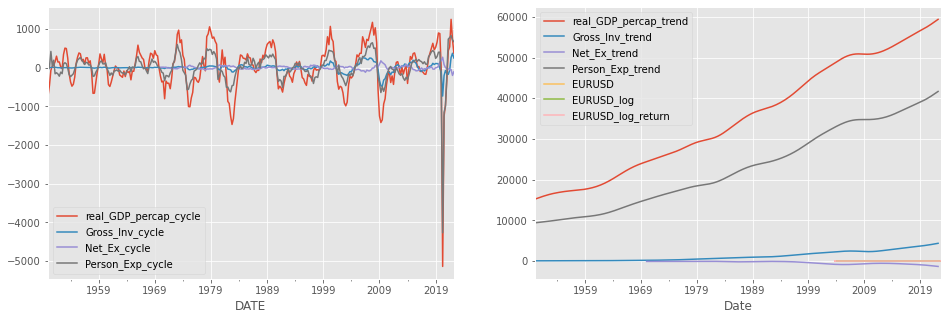

In [21]:
fig, ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
df_cycle.plot(ax=ax[0])
df_trend.plot(ax=ax[1])
df.plot(ax=ax[1])
plt.show()

Reject $H_0$ in ADF test, confirmed to be difference stationary.

In [31]:
adf_test(df_cycle['Gross_Inv_cycle'])

,statistics
Test Statistic,-5.514312
p-value,0.000002
# of Lags Used,0.000000
# of Observations Used,289.000000
Critical Value (1%),-3.453182
Critical Value (5%),-2.871593
Critical Value (10%),-2.572127


Fail to reject $H_0$ in KPSS test, confirmed to be trend stationary.

In [29]:
kpss_test(df_cycle['Gross_Inv_cycle'])

,statistics
Test Statistic,0.012959
p-value,0.100000
# of Lags,9.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


Here is a guide for combining two tests.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<h3>How to combine ADF and KPSS?</h3>
Case 1: Both tests conclude that the series is not stationary - <b>The series is not stationary</b><br>
Case 2: Both tests conclude that the series is stationary -  <b>The series is stationary </b><br>
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity -  <b>The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity. </b><br>
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity -  <b>The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity. </b>
</div>

## <font face="gotham" color="purple"> Autocorrelation Function (ACF) </font> 

The **Autocorrelation function** has also the power of testing stationarity, of most importance, the result are intuitive.

The autocorrelation of $\{r_t\}$ is commonly denoted by $\rho_k$, which is a function of $k$.

$$
\rho_{k}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\sqrt{\operatorname{Var}\left(r_{t}\right) \operatorname{Var}\left(r_{t-k}\right)}}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\operatorname{Var}\left(r_{t}\right)}=\frac{\gamma_{k}}{\gamma_{0}}
$$

The sample autocorrelation of $r_t$ with lag-$k$ is

$$
\hat{\rho}_{k}=\frac{\sum_{t=k+1}^{T}\left(r_{t}-\bar{r}\right)\left(r_{t-k}-\bar{r}\right)}{\sum_{t=1}^{T}\left(r_{t}-\bar{r}\right)^{2}}, \quad 0 \leq k<T-1
$$

One easy way to visualize autocorrelation is correlogram, which is simply a bar chart version of ACF. If the series generated by random walk process, the ACF should be near zero for all lags. 

```statsmodels.graphics.tsaplots.plot_acf``` from statsmodels library is recommended for the plot.

We also have **Partial Autocorrelation Function** (PACF), but we will discuss PACF properly later.

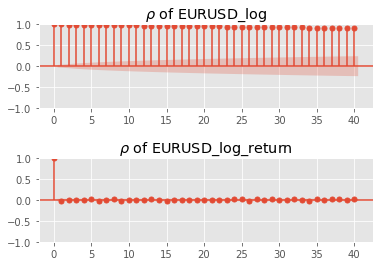

In [19]:
lags = 40 
alpha_lvl = 0.05 # level of significance, the shadow area in plot
fig, ax = plt.subplots(2, 1)
g2 = plot_acf(df['EURUSD_log'], ax=ax[0], lags=lags,
         alpha=alpha_lvl, title=r'$\rho$ of EURUSD_log')
g1 = plot_acf(df['EURUSD_log_return'], ax=ax[1], lags=lags,
          alpha=alpha_lvl, title=r'$\rho$ of EURUSD_log_return')
plt.subplots_adjust(hspace=.6)
plt.show()

As the plots show, $\rho_0=\frac{\gamma_0}{\gamma_0}=1$. A stationary series will not show any autocorrelation, like the log return series demonstrates.

## <font face="gotham" color="purple"> Ljung-Box Test </font>

The last stationary test is bit different than former ones, this one is a **Portmanteau Test**, which test joint autocorrelations of ${r_t}$. 

The **Ljung-Box Test** (LB test) is the most famous one in this category.
$$
\mathrm{LB}=n(n+2) \sum_{k=1}^{m}\left(\frac{\hat{\rho}_{k}^{2}}{n-k}\right) \sim \chi^{2}_m
$$

The hypotheses are
\begin{align}
H_0:& \text{No autocorrelation}\\
H_1:& \text{Autocorrelation presents for specified lags}
\end{align}

There have been many debates about when and how to use these statistics, but set aside those academic debate, we go lightly here. LB test is basically a joint test which depends on the specification of lags. 

For instance, if you intend measure the autocorrelation of first $10$ lags, LB test will be the ideal one. 

Here is an example.

In [20]:
sm.stats.diagnostic.acorr_ljungbox(df['EURUSD_log_return'], lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,13.452236,0.199474,13.431057,0.200559


The test shows overwhelmingly evidence for autocorrelation up to lag $10$. Note that we also add ```boxpierce``` argument in the function, this is a variant of LB test, though similar results, but usually printed out for reference.